<a href="https://colab.research.google.com/github/Prasaanth-Creator/AUTOPASS/blob/main/SVM_CLASSIFIER_EEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns

from zipfile import ZipFile

import os

%matplotlib inline

In [ ]:
# plot to check the cleaned data
def plot_data(X, xlim=[0, 20]):
    plt.figure(figsize=(15, 12) )
    
    for ind_data, data in enumerate(X):
        if ind_data == len(X) - 1:
            for ind, col in enumerate(data.columns.tolist()):
                plt.plot(t, 5 * ind + stats.zscore(data[col], nan_policy='omit'), linewidth=0.5, label=col)
            plt.legend(ncol=6)
        else:
            for ind, col in enumerate(data.columns.tolist()):
                plt.plot(t, 5 * ind + stats.zscore(data[col], nan_policy='omit'), linewidth=0.3, alpha=0.6, color='k', label=None)
    plt.xlim(xlim)


In [ ]:
# read csv data
df = pd.read_csv('/content/EEG_Eye_State_Classification.csv')

# define sampling rate, time vector, and electrode list (columns list)
Fs = 128 # (number of samples / 117s length of data mentioned on the data description) rounded to the closest integer.
t = np.arange(0, len(df) * 1 / Fs, 1/Fs)
cols = df.columns.tolist()[:-1]

print( 'Number of null samples:\n' + str(df.isnull().sum()) )
df.head()

Number of null samples:
AF3             0
F7              0
F3              0
FC5             0
T7              0
P7              0
O1              0
O2              0
P8              0
T8              0
FC6             0
F4              0
F8              0
AF4             0
eyeDetection    0
dtype: int64


,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4,eyeDetection
0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85,0
1,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10,0
2,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23,0
3,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41,0
4,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46,0


In [ ]:
# separate targets so you can preprocess the EEG data easily
Y = df['eyeDetection']
print( Y.shape )

X = df.drop(columns='eyeDetection')
print( X.shape )
X.head()

(14980,)
(14980, 14)


,AF3,F7,F3,FC5,T7,P7,O1,O2,P8,T8,FC6,F4,F8,AF4
0,4329.23,4009.23,4289.23,4148.21,4350.26,4586.15,4096.92,4641.03,4222.05,4238.46,4211.28,4280.51,4635.90,4393.85
1,4324.62,4004.62,4293.85,4148.72,4342.05,4586.67,4097.44,4638.97,4210.77,4226.67,4207.69,4279.49,4632.82,4384.10
2,4327.69,4006.67,4295.38,4156.41,4336.92,4583.59,4096.92,4630.26,4207.69,4222.05,4206.67,4282.05,4628.72,4389.23
3,4328.72,4011.79,4296.41,4155.90,4343.59,4582.56,4097.44,4630.77,4217.44,4235.38,4210.77,4287.69,4632.31,4396.41
4,4326.15,4011.79,4292.31,4151.28,4347.69,4586.67,4095.90,4627.69,4210.77,4244.10,4212.82,4288.21,4632.82,4398.46


In [ ]:
Y.head()

0    0
1    0
2    0
3    0
4    0
Name: eyeDetection, dtype: int64

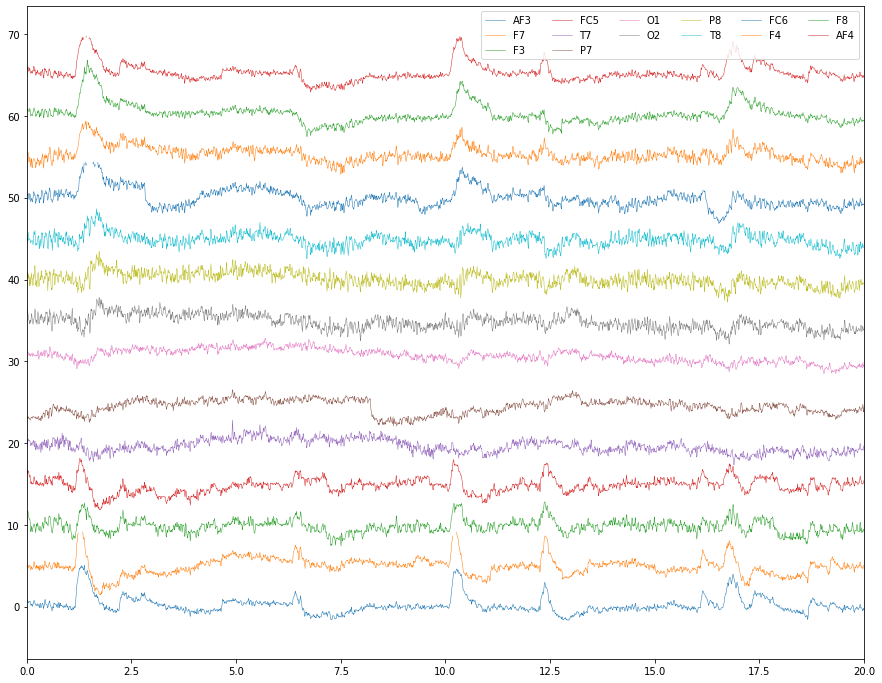

In [ ]:
# Find outliers and put Nan instead
X = X.apply(stats.zscore, axis=0)
X = X.applymap(lambda x: np.nan if (abs(x) > 4) else x )

# recalculate outliers with ignoring nans since the first calculation was biased with the huge outliers!
X = X.apply(stats.zscore, nan_policy='omit', axis=0)
X = X.applymap(lambda x: np.nan if (abs(x) > 4) else x )

plot_data([X])

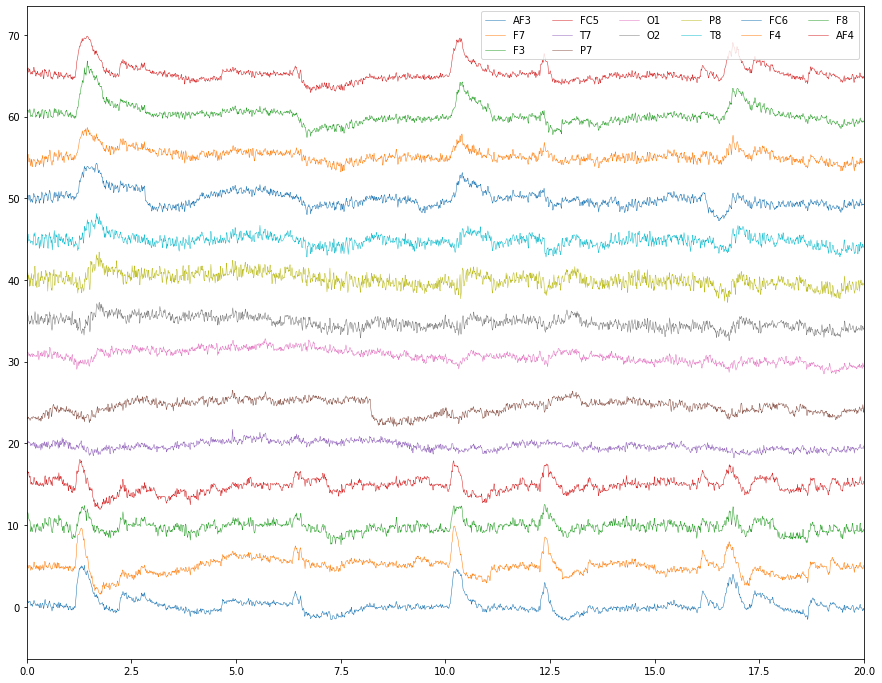

In [ ]:
from scipy import signal, interpolate

def interp(x):
    t_temp = t[ x.index[ ~x.isnull() ] ]
    x = x[ x.index[ ~x.isnull() ] ]
    clf = interpolate.interp1d(t_temp, x, kind='cubic')
    return clf(t)

# interpolate the nans using cubic spline method
X_interp = X.apply(interp, axis=0)

plot_data([X_interp])


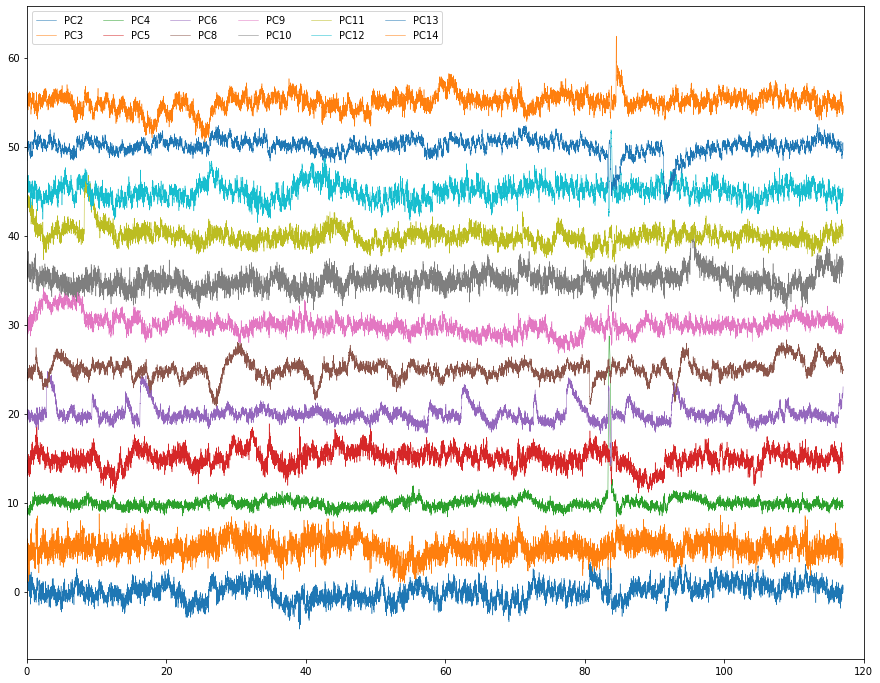

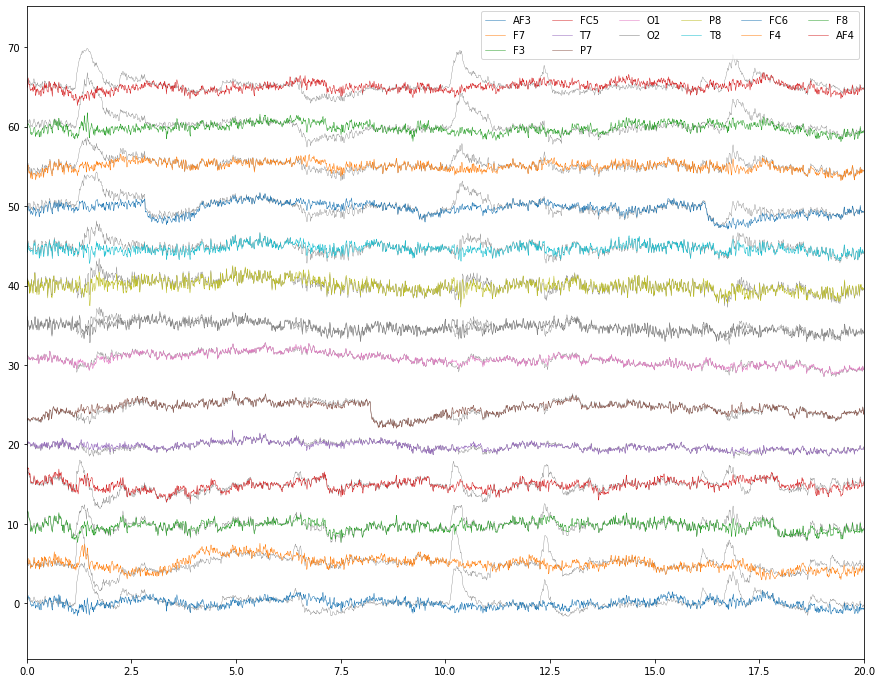

In [ ]:
# ICA
from sklearn.decomposition import FastICA

# apply ICA to drop non-electrophysiolgoical components (requires familiarity with EEG data)
ica = FastICA(max_iter=2000, random_state=0)
X_pcs = pd.DataFrame( ica.fit_transform(X_interp) )
X_pcs.columns = ['PC' + str(ind+1) for ind in range(X_pcs.shape[-1])]
X_pcs = X_pcs.drop(columns=['PC1', 'PC7'])
plot_data([X_pcs], xlim=[0, 120])

# reconstruct clean EEG after dropping the bad components
ica.mixing_ = np.delete(ica.mixing_, [0, 6], axis = 1)
X_interp_clean = pd.DataFrame( ica.inverse_transform(X_pcs) )
X_interp_clean.columns = cols

plot_data([X_interp, X_interp_clean], xlim=[0, 20])


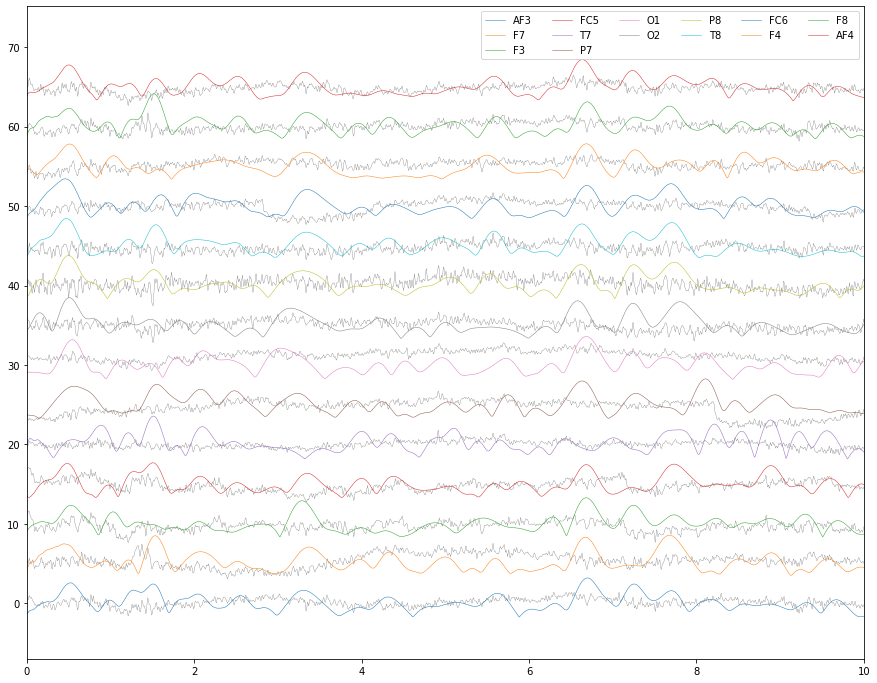

In [ ]:
# now that data is clean, extract alpha waves magnitude from the clean signals

# filter the data between 8-12 Hz (note that data has been rescaled to original scale after filtering for comparable visualization)
b, a = signal.butter(6, [8 / Fs * 2, 12 / Fs * 2], btype='bandpass')
X_interp_clean_alpha = X_interp_clean.apply(lambda x: signal.filtfilt(b, a, x) / max(abs(signal.filtfilt(b, a, x))) * max(abs(x)), axis=0)

# extract envelope of the Alpha waves
X_interp_clean_alpha = X_interp_clean_alpha.apply(lambda x: np.abs(signal.hilbert(x)), axis=0)
X_interp_clean_alpha.columns = cols

plot_data([X_interp_clean, X_interp_clean_alpha], xlim=[0, 10])

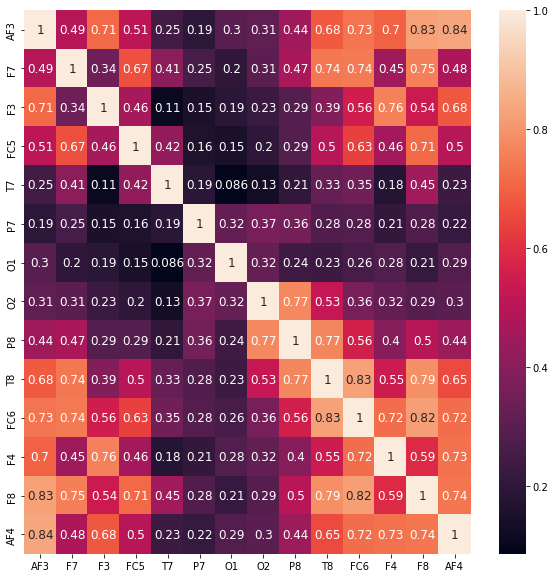

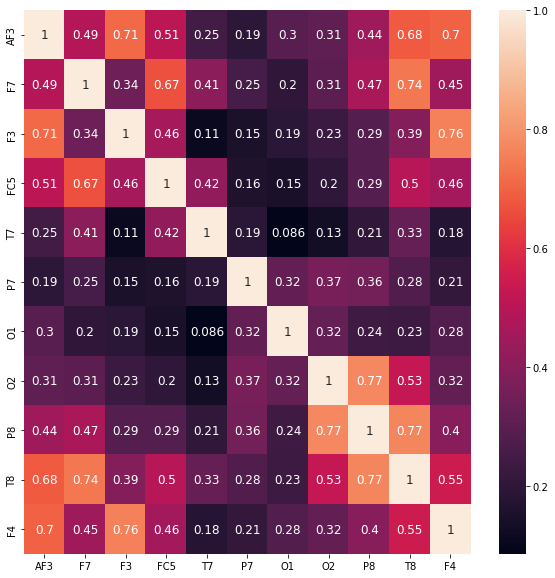

In [ ]:
# drop features with high correlations
X = X_interp_clean_alpha
Cols_corr = X.corr()

# plot correlations of the cols
plt.figure( figsize=(10,10) )
sns.heatmap(Cols_corr, annot=True, annot_kws={'fontsize':12})

# exclude columns with high correlation
cols_drop_ind = [0] * len(cols)
for i in range(len(cols)):
    for j in range(len(cols)):
        if (i<j) & abs( Cols_corr.iloc[i, j] >= 0.8):
            cols_drop_ind[j] = 1

cols_drop = [cols[ind] for ind in range(len(cols_drop_ind)) if cols_drop_ind[ind]]
X.drop(columns=cols_drop, inplace=True)

plt.figure( figsize=(10,10) )
sns.heatmap(X.corr(), annot=True, annot_kws={'fontsize':12})
    

Variance ratio explained by the components is :[0.45288691 0.25721336]


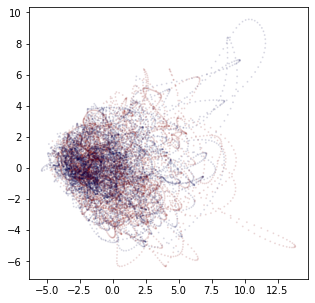

In [ ]:
# just to check if the labels are linearly separable with less features! (Seems like we can't!)

from sklearn.decomposition import PCA
from matplotlib import interactive

N = 2
pca = PCA(n_components=N)
X_pca = pd.DataFrame( pca.fit_transform(X), columns=['PC' + str(i+1) for i in range(N)])
print( 'Variance ratio explained by the components is :' + str(pca.explained_variance_ratio_))

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
_ = ax.scatter(X_pca['PC1'], X_pca['PC2'], s = 1, c=Y, cmap='seismic', alpha=0.1)

In [ ]:
# train an SVM to classify
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

# split train test data
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=48, test_size=0.2, stratify=Y, shuffle=True)

# normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
from sklearn.metrics import roc_auc_score

# train with grid search
svc = SVC()
parameters = {'gamma': [0.1, 1, 10], 'C': [0.1, 1, 10]}
clf = GridSearchCV(svc, parameters)
clf.fit(X_train, y_train)

# predict labels
y_pred = clf.predict(X_test)

# extract accuracy (r2 score)
results = roc_auc_score(y_test, y_pred)

# print score
print( 'Score is: ' + str( results ) )
print( 'Best params for the kernel SVM is: ' + str(clf.best_params_) )

Score is: 0.9976044708737973
Best params for the kernel SVM is: {'C': 10, 'gamma': 1}


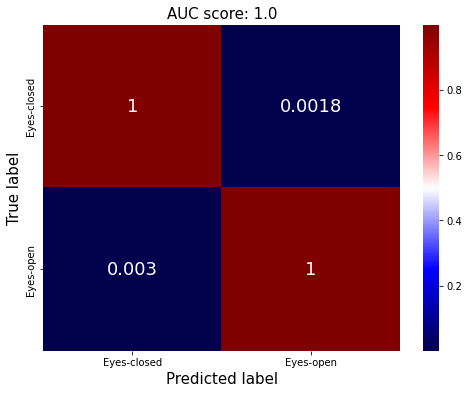

In [ ]:
from sklearn.metrics import confusion_matrix

# confusion matrix estimation
conf = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(8,6))
sns.heatmap(conf, annot=True, cmap='seismic', annot_kws={'fontsize':18})
_ = plt.title( 'AUC score: ' + str(round(results, 2) ), fontsize=15)
_ = plt.xticks(ticks=[0.5, 1.5], labels=['Eyes-closed', 'Eyes-open'])
_ = plt.yticks(ticks=[0.5, 1.5], labels=['Eyes-closed', 'Eyes-open'])
_ = plt.ylabel('True label', fontsize=15)
_ = plt.xlabel('Predicted label', fontsize=15)